# Config.

### Import Modules

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

###### Data Cleaning
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

###### Regression Models 
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

##### Measuring models
from sklearn.model_selection import cross_val_score

#from sklearn.ensemble import *
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier

# My modules
from src import datahandler

### Configure `PATH` for `LOCAL JUPYTER` or `Google Colab`

    # Google Colab Setup
    from os.path import join
    from google.colab import drive
    from google.colab import output

    ROOT = "/content/drive"
    drive.mount(ROOT)

    PATH = "drive/My Drive/data/"

    # Play a sound when training is finished
    def makesound():
      output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/3/34/Sound_Effect_-_Door_Bell.ogg").play()')

In [2]:
# Local Jupyter Setup
PATH='../'

# Load Training Dataset as `raw_data_train`

In [3]:
raw_data_train = pd.read_csv(f'{PATH}INPUT/diamonds_train.csv').drop(columns='Unnamed: 0')
raw_data_train.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.21,Ideal,H,VS2,63.0,57.0,6.73,6.70,4.23,6134
1,0.28,Very Good,D,VVS2,64.0,56.0,4.14,4.17,2.66,532
2,0.42,Premium,F,VS1,61.2,58.0,4.86,4.82,2.96,1103
3,0.26,Ideal,H,IF,61.1,57.0,4.16,4.12,2.53,600
4,1.10,Good,G,SI1,63.4,57.0,6.52,6.55,4.14,4997


In [4]:
###### `dtypes`

In [5]:
raw_data_train.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price        int64
dtype: object

In [6]:
###### `value_counts`

In [7]:
# Diamond Cut
raw_data_train.cut.value_counts()

Ideal        16090
Premium      10339
Very Good     9036
Good          3694
Fair          1186
Name: cut, dtype: int64

In [8]:
# Diamond Color
raw_data_train.color.value_counts()

G    8499
E    7351
F    7130
H    6234
D    5074
I    4023
J    2034
Name: color, dtype: int64

In [9]:
# Diamond Clarity
raw_data_train.clarity.value_counts()

SI1     9751
VS2     9178
SI2     6828
VS1     6101
VVS2    3858
VVS1    2714
IF      1362
I1       553
Name: clarity, dtype: int64

In [10]:
### Values to predict, a.k.a. : `label`

In [11]:
# LABEL: Diamond Price
raw_data_train.price.value_counts().head()

625    99
789    96
605    95
776    94
596    93
Name: price, dtype: int64

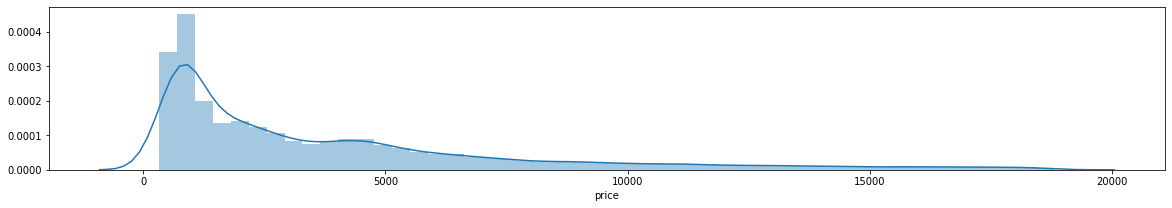

In [12]:
plt.figure(figsize=(20,3))
sns.distplot(raw_data_train.price)

## Notes from a basic investigation:

    This problem uses continuous data, which is the 'price' of the diamond, and consists of a range of infinite values.

    The objective is to generate predictions with a low Root Mean Squared Error (RMSE)

    """
    After interviewing a Diamond seller, they have recommended the use of 4 main features which are considered when calculating the price of a diamond... If these features are all positive, have "balanced values", such as clarity, color, etc. the diamond will sell with a very high price.
    """
    
    """
    The dataset contains no null values. It is composed of 8 coninuous variables and 3 categorical values.
    """
    
    """
    By looking at the distribution of the `prices`, we can see that the diamonds are more frequently under price of `5000`. Although the maximum price registered is around `20000`, giving this data to our model could actually make it less precise.
    """
    
    """
    another observation here
    """


# Data States

We'll make a dictionary with the different `states` of the data, and we will be updating this dictionary as we create new `data_states`, in order to use them easily with our models.

- Proposed Data States:
    - `raw`: The raw data, without any modifications.
    - `max_price`: Raw data, but dropping all rows with a price that goes over a defined `max_price`. It includes categorical and continuous features.
    - `numerical_features`: Turn the categorical (object) dtypes into numerics. (using one-hot encoding or label encoding)
    - `continuous_features`: Discarding all categorical features.
    - `main_features`: Only include the main features described by the diamond seller.
    

### `data_input_states['raw']`

In [13]:
data_input_states = {}
data_input_states.update({'raw':raw_data_train})

### `data_input_states['max_price']`

In [14]:
# Define our filter
max_price = 12000

# Making a subset of data with fewer outliers
data = data_input_states['raw'].copy()
data = data[data.price < max_price]
data.price.describe()

data_input_states.update({'max_price':data})

### `data_input_states['numerical_features']`


In this case, it would be good to look deeper into how much difference is there between all the GIA `clarity` categories, as they might not follow a linear scale.

In [15]:
data.color.value_counts()

G    7959
E    7062
F    6759
H    5765
D    4872
I    3577
J    1783
Name: color, dtype: int64

In [16]:
data = data_input_states['raw'].copy()

cleanup_nums = {"clarity":    { 'IF':   0,
                                'VVS1': 1, 'VVS2':2,
                                'VS1':  3,  'VS2':4,
                                'SI1':  5,  'SI2':6,
                                'I1':   7,},
                
                "cut": {'Fair':4, 'Good':3,'Very Good':2, 'Premium':1,'Ideal':0},
               
                "color": {'D':6, 'E':5, 'F':4, 'G':3,'H':2, 'I':1, 'J':0}
               }
data.replace(cleanup_nums, inplace=True)
data_input_states.update({'numerical_features':data})

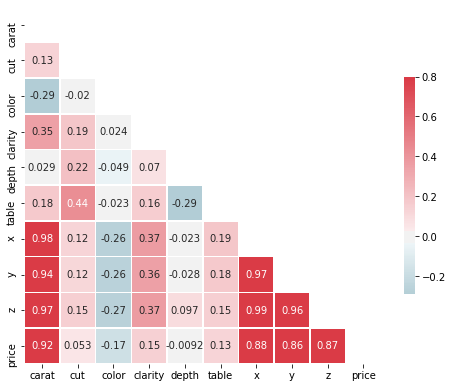

In [17]:
datahandler.corr_matrix(data_input_states['numerical_features'])

### Normalization and Standarization

In [18]:
# Choose one of the data_input_states
data = data_input_states['numerical_features'].copy()

In [19]:
data_input_states

{'raw':        carat        cut color clarity  depth  table     x     y     z  price
 0       1.21      Ideal     H     VS2   63.0   57.0  6.73  6.70  4.23   6134
 1       0.28  Very Good     D    VVS2   64.0   56.0  4.14  4.17  2.66    532
 2       0.42    Premium     F     VS1   61.2   58.0  4.86  4.82  2.96   1103
 3       0.26      Ideal     H      IF   61.1   57.0  4.16  4.12  2.53    600
 4       1.10       Good     G     SI1   63.4   57.0  6.52  6.55  4.14   4997
 ...      ...        ...   ...     ...    ...    ...   ...   ...   ...    ...
 40340   1.55    Premium     H     VS2   61.3   61.0  7.46  7.39  4.55  11708
 40341   0.36      Ideal     D     SI1   60.6   56.0  4.58  4.63  2.79    619
 40342   0.57  Very Good     I     VS2   62.2   55.0  5.33  5.34  3.32   1267
 40343   1.01  Very Good     F      IF   59.6   62.0  6.47  6.56  3.88   9965
 40344   0.54      Ideal     E     SI2   60.4   57.0  5.33  5.27  3.20   1340
 
 [40345 rows x 10 columns],
 'max_price':        carat 

In [22]:
for key in data_input_states:
    data_input_states[key].to_csv(f'../OUTPUT/{key}.csv')

raw
max_price
numerical_features


# Preparing variables `X` and `y`

In [20]:
X = data.drop(columns='price')
y = data.price